In [9]:
import numpy
import matplotlib.pyplot as plt
import torch
import torch_geometric as tg
from gen_dataset import PlaneGraphDataset
from tqdm import trange

In [6]:
dataset = PlaneGraphDataset(root='plane_graphs', n_graphs_per_type=300)
dataset.process()
train_loader = tg.loader.DataLoader(dataset[:800], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[800:], batch_size=16, shuffle=True)
dataset[110].edge_index

100%|██████████| 900/900 [00:03<00:00, 261.10it/s]
c:\Users\steph\OneDrive\Dokumente\VS Code\Python\Computerpraktikum\gen_dataset.py:55: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental f

tensor([[ 0,  1,  0,  ..., 98, 98, 99],
        [ 1,  0, 10,  ..., 97, 99, 98]])

In [7]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = tg.nn.GCNConv(dataset.num_features, 4)
        self.conv2 = tg.nn.GCNConv(4,8)
        self.classifier = torch.nn.Linear(8, dataset.num_classes)
    def forward(self, x, edge_index, batch):
        x = torch.tanh(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
    
        x = tg.nn.global_mean_pool(x, batch)
        out = torch.nn.functional.softmax(self.classifier(x), dim=1)
        
        return out
model1 = GCN()
print(model1)

optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.01)
criterion1 = torch.nn.CrossEntropyLoss()

def train1(loader):
    model1.train()
    for data in loader:
        out = model1(data.x, data.edge_index, data.batch)# Perform a single forward pass.
        loss = criterion1(out, data.y)  # Compute the loss.
        #print(loss)
        loss.backward()  # Derive gradients.
        optimizer1.step()  # Update parameters based on gradients.
        optimizer1.zero_grad() # Reset grads.
def test1(loader):
    model1.eval()
    correct = 0
    for data in loader:
        out = model1(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        true = data.y.argmax(dim=1)
        #print(true)
        correct += int((true == pred).sum())
    return correct / len(loader.dataset)

class GINEConv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(12345)
        self.conv1 = tg.nn.GINEConv(torch.nn.Linear(dataset.num_features, 4), edge_dim=2)
        self.conv2 = tg.nn.GINEConv(torch.nn.Linear(4, 8), edge_dim=2)
        self.classifier = torch.nn.Linear(8, dataset.num_classes)
    def forward(self, x, edge_index, edge_attr, batch):
        x = torch.tanh(self.conv1(x, edge_index, edge_attr))
        x = torch.tanh(self.conv2(x, edge_index, edge_attr))
        x = tg.nn.global_mean_pool(x, batch)
        out = torch.nn.functional.softmax(self.classifier(x), dim=1)
        
        return out
model2 = GINEConv()
print(model2)

optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.01)
criterion2 = torch.nn.CrossEntropyLoss()

def train2(loader):
    model2.train()
    for data in loader:
        out = model2(data.x, data.edge_index, data.edge_attr, data.batch)# Perform a single forward pass.
        loss = criterion2(out, data.y)  # Compute the loss.
        #print(loss)
        loss.backward()  # Derive gradients.
        optimizer2.step()  # Update parameters based on gradients.
        optimizer2.zero_grad() # Reset grads.
def test2(loader):
    model2.eval()
    correct = 0
    for data in loader:
        out = model2(data.x, data.edge_index, data.edge_attr, data.batch)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        true = data.y.argmax(dim=1)
        #print(true)
        correct += int((true == pred).sum())
    return correct / len(loader.dataset)

GCN(
  (conv1): GCNConv(2, 4)
  (conv2): GCNConv(4, 8)
  (classifier): Linear(in_features=8, out_features=3, bias=True)
)
GINEConv(
  (conv1): GINEConv(nn=Linear(in_features=2, out_features=4, bias=True))
  (conv2): GINEConv(nn=Linear(in_features=4, out_features=8, bias=True))
  (classifier): Linear(in_features=8, out_features=3, bias=True)
)


Epoch: 001, Train Accuracy: 0.57, Test Accuracy: 0.55
Epoch: 002, Train Accuracy: 0.89, Test Accuracy: 0.85
Epoch: 003, Train Accuracy: 0.89, Test Accuracy: 0.86
Epoch: 004, Train Accuracy: 0.88, Test Accuracy: 0.86
Epoch: 005, Train Accuracy: 0.89, Test Accuracy: 0.88
Epoch: 006, Train Accuracy: 0.90, Test Accuracy: 0.85
Epoch: 007, Train Accuracy: 0.89, Test Accuracy: 0.86
Epoch: 008, Train Accuracy: 0.89, Test Accuracy: 0.88
Epoch: 009, Train Accuracy: 0.90, Test Accuracy: 0.87
Epoch: 010, Train Accuracy: 0.89, Test Accuracy: 0.88
Epoch: 011, Train Accuracy: 0.90, Test Accuracy: 0.88
Epoch: 012, Train Accuracy: 0.90, Test Accuracy: 0.86
Epoch: 013, Train Accuracy: 0.87, Test Accuracy: 0.88
Epoch: 014, Train Accuracy: 0.90, Test Accuracy: 0.86
Epoch: 015, Train Accuracy: 0.90, Test Accuracy: 0.86
Epoch: 016, Train Accuracy: 0.88, Test Accuracy: 0.86
Epoch: 017, Train Accuracy: 0.90, Test Accuracy: 0.87
Epoch: 018, Train Accuracy: 0.90, Test Accuracy: 0.87
Epoch: 019, Train Accuracy: 

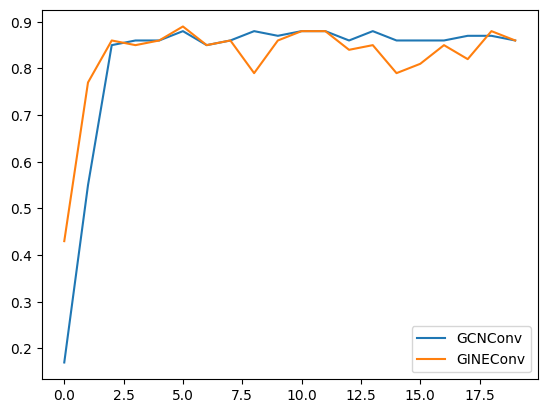

In [8]:
accs = []
acc = test1(test_loader)
accs.append(acc)
for epoch in trange(1, 20):
    train1(train_loader)
    train_acc = test1(train_loader)
    test_acc = test1(test_loader)
    accs.append(test_acc)
    if epoch <5:
        print(f'Epoch: {epoch:03d}, Train Accuracy: {train_acc:.2f}, Test Accuracy: {test_acc:.2f}')
plt.plot(accs, label= 'GCNConv')

accs = []
acc = test2(test_loader)
accs.append(acc)
for epoch in trange(1, 20):
    train2(train_loader)
    train_acc = test2(train_loader)
    test_acc = test2(test_loader)
    accs.append(test_acc)
    if epoch <5:
        print(f'Epoch: {epoch:03d}, Train Accuracy: {train_acc:.2f}, Test Accuracy: {test_acc:.2f}')
plt.plot(accs, label='GINEConv')
plt.legend()
plt.show()
